In [1]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

In [2]:
output = True
N = 9
q = naminoacids

proteome = proteome_path('Human')
seed = 1234
prng = np.random.RandomState(seed)

In [3]:
seqs = [s for s in fasta_iter(proteome, returnheader=False)]
train, test = train_test_split(seqs, test_size=0.5, random_state=prng)

In [4]:
train_arr =  np.array([list(kmer) for kmer in to_kmers(train, k=N)])
train_matrix = map_matrix(train_arr, map_)

In [5]:
np.savetxt('data/train_matrix.csv.gz', train_matrix, fmt='%i')

In [6]:
fi = frequencies(train_matrix, num_symbols=q, pseudocount=1e-3)
fij = pair_frequencies(train_matrix, num_symbols=q, fi=fi, pseudocount=1e-3)
cij = compute_covariance_matrix(fi, fij)

In [7]:
test_arr =  np.array([list(kmer) for kmer in to_kmers(test, k=N)])
test_matrix = map_matrix(test_arr, map_)

In [8]:
fi_test = frequencies(test_matrix, num_symbols=q, pseudocount=1e-3)
fij_test = pair_frequencies(test_matrix, num_symbols=q, fi=fi_test, pseudocount=1e-3)
cij_test = compute_covariance_matrix(fi_test, fij_test)

In [9]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [ ]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
sample_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi, Jij), jump, 1e7, nsample=10)

In [ ]:
fi_model = frequencies(sample_matrix, num_symbols=q)
fij_model = pair_frequencies(sample_matrix, num_symbols=q, fi=fi_model)
cij_model = compute_covariance_matrix(fi_model, fij_model)

In [ ]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)

ax = axes[0]
ax.plot(fi, fi_model, 'o', ms=2)
ax.set_xlabel('training $f_i$')
ax.set_ylabel('maxent $f_i$')
ax.plot([0, 0.12], [0, 0.12], 'k')

lim = 0.002
ax = axes[1]
mask = ~np.eye(cij.shape[0], dtype=bool)
ax.plot(cij[mask].flatten(), cij_model[mask].flatten(), 'o', ms=2)
ax.set_ylabel('maxent $c_{ij}$')
ax.set_xlabel('training $c_{ij}$')
ax.plot([-lim, lim], [-lim, lim], 'k')

fig.tight_layout()

In [13]:
import evcouplings.align, evcouplings.couplings

Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)

In [14]:
def JijfrominvC(invC):
    Jij = evcouplings.couplings.reshape_invC_to_4d(invC, N, q)
    Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)
    return Jij_zerogauge

In [20]:
cij_flat = compute_flattened_covariance_matrix(fi, fij)
invC = np.linalg.inv(cij_flat)
Jij_mf = JijfrominvC(invC)
hi_mf = evcouplings.couplings.fields(Jij_mf, fi)

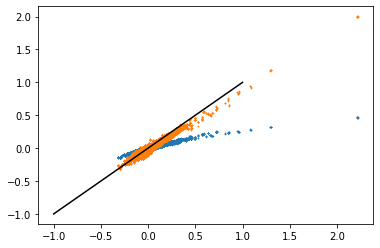

In [16]:
k = N
rhoij = np.zeros(fij.shape)
for i in range(k):
    for j in range(k):
        rhoij[i, j] = fij[i, j]/np.outer(fi[i], fi[j]) - 1.0
mask = np.abs(Jij_zerogauge) > 1e-5
plt.plot(rhoij[mask].flatten(), Jij_zerogauge[mask].flatten(), '.', ms=1)
mask = np.abs(Jij_mf) > 1e-5
plt.plot(rhoij[mask].flatten(), Jij_mf[mask].flatten(), '.', ms=1)
lim = 1.0
plt.plot([-lim, lim], [-lim, lim], 'k-')

In [21]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
sample_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi_mf, -Jij_mf), jump, 1e7, nsample=10)

In [22]:
fi_mf = frequencies(sample_matrix, num_symbols=q)
fij_mf = pair_frequencies(sample_matrix, num_symbols=q, fi=fi_model)
cij_mf = compute_covariance_matrix(fi_mf, fij_mf)

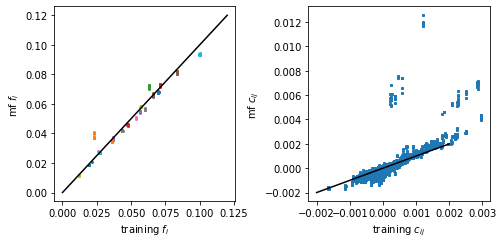

In [23]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)

ax = axes[0]
ax.plot(fi, fi_mf, 'o', ms=2)
ax.set_xlabel('training $f_i$')
ax.set_ylabel('mf $f_i$')
ax.plot([0, 0.12], [0, 0.12], 'k')

lim = 0.002
ax = axes[1]
mask = ~np.eye(cij.shape[0], dtype=bool)
ax.plot(cij[mask].flatten(), cij_mf[mask].flatten(), 'o', ms=2)
ax.set_ylabel('mf $c_{ij}$')
ax.set_xlabel('training $c_{ij}$')
ax.plot([-lim, lim], [-lim, lim], 'k')

fig.tight_layout()